# What we are doing
- We are following a portion of a tutorial outlined in this paper: https://doi.org/10.1038/s41596-020-0353-1.
- The portion we are following is running a PRS analysis of height, using simulated data.
- We will take data files provided, do necessary data wrangling to get the data in the right format.
- After the data is in the right format, we will perform PRS using PRSice-2.
- We will run a scatter plot of our results, and compare it to sample results.

# Requirements
- Download `post-qc.zip` from [this link](https://drive.google.com/file/d/1x_G0Gxk9jFMY-PMqwtg6-vdEyUPp5p5u/view) and unzip its contents into the same directory as this notebook.
- Download PRSice-2 from [this link](https://www.prsice.info/), and place it in the same directory as the contents of this notebook.
    - Note: depending on your OS, you will need to download the correct executable and adapt some of the code provided in this notebook.
    - Windows users can use the Linux executable via WSL (Windows Subsystem for Linux).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

## Data wrangling
Before we run PRSice-2, we need a single covariate file, which can be obtained by merging sex data from `EUR.cov` and principal components from `EUR.eigenvec`. We will write the merged data to a file called `EUR.covariate`.

In [2]:
cov = pd.read_csv('EUR.cov', sep='\t')
pcs = pd.read_csv('EUR.eigenvec', sep='\s+', header=None)
pcs.columns = ['FID', 'IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']

covariate = pd.merge(cov, pcs, on=['FID', 'IID'])
covariate.to_csv('EUR.covariate', index=False, sep='\t')

## Running a PRS analysis with PRSice-2
We will use the PRSice executable we downloaded to run the PRS analysis on our data files.  
Note: you may need to adapt the code here to match your OS.

You can also do this step outside of the notebook (just make sure the output files are in the same directoy as this notebook).

#### PRSice parameter descriptions

| Parameter     | Value         | Description                                                                                          |
|---------------|---------------|------------------------------------------------------------------------------------------------------|
| base          | Height.QC.gz  | Informs PRSice that the name of the GWAS summary statistic                                           |
| target        | EUR.QC        | Informs PRSice that the input genotype files should have a prefix of `EUR.QC`                          |
| binary-target | F             | Indicate if the phenotype of interest is a binary trait. F for false.                                    |
| pheno         | EUR.height    | Provide PRSice with the phenotype file                                                               |
| cov           | EUR.covariate | Provide PRSice with the covariate file                                                               |
| base-maf      | MAF:0.01      | Filter out SNPs with MAF < 0.01 in the GWAS summary statistics, using information in the `MAF` column  |
| base-info     | INFO:0.8      | Filter out SNPs with INFO < 0.8 in the GWAS summary statistics, using information in the `INFO` column |
| stat          | OR            | Column name of the column containing the effect size                                                 |
| or            |              | Inform PRSice that the effect size is an Odds Ratio                                                   |
| out           | EUR           | Informs PRSice that all output should have a prefix of `EUR`   

In [3]:
%%bash
./PRSice_linux \
    --base Height.QC.gz \
    --target EUR.QC \
    --binary-target F \
    --pheno EUR.height \
    --cov EUR.covariate \
    --base-maf MAF:0.01 \
    --base-info INFO:0.8 \
    --stat OR \
    --or \
    --out EUR

PRSice 2.3.3 (2020-08-05) 
https://github.com/choishingwan/PRSice
(C) 2016-2020 Shing Wan (Sam) Choi and Paul F. O'Reilly
GNU General Public License v3
If you use PRSice in any published work, please cite:
Choi SW, O'Reilly PF.
PRSice-2: Polygenic Risk Score Software for Biobank-Scale Data.
GigaScience 8, no. 7 (July 1, 2019)
2021-06-04 17:39:16
./PRSice_linux \
    --a1 A1 \
    --a2 A2 \
    --bar-levels 0.001,0.05,0.1,0.2,0.3,0.4,0.5,1 \
    --base Height.QC.gz \
    --base-info INFO:0.8 \
    --base-maf MAF:0.01 \
    --binary-target F \
    --bp BP \
    --chr CHR \
    --clump-kb 250kb \
    --clump-p 1.000000 \
    --clump-r2 0.100000 \
    --cov EUR.covariate \
    --interval 5e-05 \
    --lower 5e-08 \
    --num-auto 22 \
    --or  \
    --out EUR \
    --pheno EUR.height \
    --pvalue P \
    --seed 209189107 \
    --snp SNP \
    --stat OR \
    --target EUR.QC \
    --thread 1 \
    --upper 0.5

Initializing Genotype file: EUR.QC (bed) 

Start processing Height.QC 

Base f

## Some final data wrangling
We need to merge height data from `EUR.height`, sex data from `EUR.cov` with polygenic scores from `EUR.best`.  
We will also make the sex data human readable by converting `1 -> Female` and `2 -> Male`.

In [4]:
best = pd.read_csv('EUR.best', sep='\s+')
height = pd.read_csv('EUR.height', sep='\s+')
cov = pd.read_csv('EUR.cov', sep='\s+')

results = pd.merge(height, best, on=['FID', 'IID'])
results = pd.merge(results, cov, on=['FID', 'IID'])

results['Sex'] = results['Sex'].apply(lambda x: 'Female' if x == 1 else 'Male')
results.head()

,FID,IID,Height,In_Regression,PRS,Sex
0,HG00096,HG00096,169.132169,Yes,-0.000019,Female
1,HG00097,HG00097,171.256259,Yes,0.000013,Male
2,HG00099,HG00099,171.534380,Yes,-0.000003,Male
3,HG00101,HG00101,169.850176,Yes,0.000009,Female
4,HG00102,HG00102,172.788361,Yes,0.000017,Male


## Plotting our results
For each sex, we will  calculate the Pearson correlation coefficient between polygenic score and height to include in our scatter plot.

In [5]:
females = results[results['Sex'] == 'Female']
males = results[results['Sex'] == 'Male']

r_female = females[['Height', 'PRS']].corr().iloc[0, 1]
r_male = males[['Height', 'PRS']].corr().iloc[0, 1]

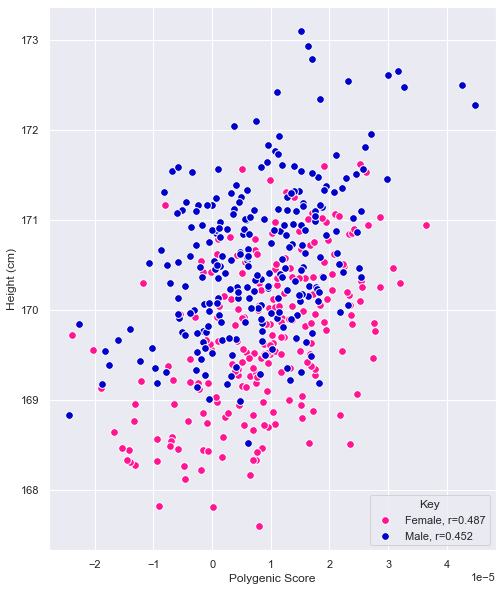

In [6]:
plt.figure(figsize=(8, 10))

plt.scatter(females['PRS'], females['Height'],
            c='deeppink', edgecolors='w', s=60,
            label='Female, r={:.3f}'.format(r_female))
plt.scatter(males['PRS'], males['Height'],
            c='mediumblue', edgecolors='w', s=60,
            label='Male, r={:.3f}'.format(r_male))

plt.legend(loc='lower right', title='Key')

plt.xlabel('Polygenic Score')
plt.ylabel('Height (cm)');

## Comparing our results
The authors of the paper (Choi et al.) also ran an analysis on the same data and made a scatter plot. Let's compare plots to see how well we did.

Choi et al.'s scatter plot can be found at the bottom of [this page](https://choishingwan.github.io/PRS-Tutorial/plink_visual/).

It looks good!

There are some minor discrepancies as Choi et al.'s PRS analysis was generated using a manually picked P-value threshold of 0.3, whereas our analysis' P-value threshold was picked by PRSice's "best-fit" algorithm.